In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
sns.set(color_codes=True)
pd.set_option('display.max_columns', 100)

In [2]:
history_data = pd.read_csv("history_data.csv")
train = pd.read_csv("train.csv")

# 1. Feature Engineering

Since we have the consumption data for each of the companies for the year 2015, we will create new features using the average of the year, the last six months, and the last three months to our model

In [3]:
mean_year = history_data.groupby(["id"]).mean().reset_index()

In [4]:
mean_6m = history_data[history_data["price_date"] > "2015-06-01"].groupby(["id"]).mean().reset_index()

In [5]:
mean_3m = history_data[history_data["price_date"] > "2015-10-01"].groupby(["id"]).mean().reset_index()

In [6]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
                                                 "price_p2_var": "mean_year_price_p2_var",
                                                 "price_p3_var": "mean_year_price_p3_var",
                                                 "price_p1_fix": "mean_year_price_p1_fix",
                                                 "price_p2_fix": "mean_year_price_p2_fix",
                                                 "price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [7]:
mean_6m = mean_6m.rename(index=str, columns={"price_p1_var": "mean_6m_price_p1_var",
                                             "price_p2_var": "mean_6m_price_p2_var",
                                             "price_p3_var": "mean_6m_price_p3_var",
                                             "price_p1_fix": "mean_6m_price_p1_fix",
                                             "price_p2_fix": "mean_6m_price_p2_fix",
                                             "price_p3_fix": "mean_6m_price_p3_fix",})
mean_6m["mean_6m_price_p1"] = mean_6m["mean_6m_price_p1_var"] + mean_6m["mean_6m_price_p1_fix"]
mean_6m["mean_6m_price_p2"] = mean_6m["mean_6m_price_p2_var"] + mean_6m["mean_6m_price_p2_fix"]
mean_6m["mean_6m_price_p3"] = mean_6m["mean_6m_price_p3_var"] + mean_6m["mean_6m_price_p3_fix"]

In [8]:
mean_3m = mean_3m.rename(index=str, columns={"price_p1_var": "mean_3m_price_p1_var",
                                             "price_p2_var": "mean_3m_price_p2_var",
                                             "price_p3_var": "mean_3m_price_p3_var",
                                             "price_p1_fix": "mean_3m_price_p1_fix",
                                             "price_p2_fix": "mean_3m_price_p2_fix",
                                             "price_p3_fix": "mean_3m_price_p3_fix",})
mean_3m["mean_3m_price_p1"] = mean_3m["mean_3m_price_p1_var"] + mean_3m["mean_3m_price_p1_fix"]
mean_3m["mean_3m_price_p2"] = mean_3m["mean_3m_price_p2_var"] + mean_3m["mean_3m_price_p2_fix"]
mean_3m["mean_3m_price_p3"] = mean_3m["mean_3m_price_p3_var"] + mean_3m["mean_3m_price_p3_fix"]

Now we will merge them into a single dataframe.

Note: I am not confident the mean_6m and mean_3m could help the prediction model. We will see below the variables are also highly correlated to actually using only the mean_year is OK.

In [9]:
#features = pd.merge(mean_year,mean_6m, on="id")
#features = pd.merge(features,mean_3m, on="id")
features = mean_year

In [10]:
features.columns

Index(['id', 'Unnamed: 0', 'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3'],
      dtype='object')

In [11]:
train['date_end'] = pd.to_datetime(train['date_end'])
train['date_activ'] = pd.to_datetime(train['date_activ'])

In [12]:
train['date_modif_prod'] = pd.to_datetime(train['date_modif_prod'])
train['date_renewal'] = pd.to_datetime(train['date_renewal'])

In [13]:
train.dtypes

Unnamed: 0                           int64
id                                  object
activity_new                        object
channel_sales                       object
cons_12m                             int64
cons_gas_12m                         int64
cons_last_month                      int64
date_activ                  datetime64[ns]
date_end                    datetime64[ns]
date_modif_prod             datetime64[ns]
date_renewal                datetime64[ns]
forecast_cons_12m                  float64
forecast_cons_year                   int64
forecast_discount_energy           float64
forecast_meter_rent_12m            float64
forecast_price_energy_p1           float64
forecast_price_energy_p2           float64
forecast_price_pow_p1              float64
has_gas                             object
imp_cons                           float64
margin_gross_pow_ele               float64
margin_net_pow_ele                 float64
nb_prod_act                          int64
net_margin 

In the previous notebook we explored the data and made a deep dive into the churn by dates. Nonetheless, that exploration was quite shallow and did not provide us with any relevant insight.
What if we could create a new variable that could provide us more relevant insights?

We will define a variable.
tenure = date_end - date_activ

In [14]:
train["tenure"] = ((train["date_end"] - train["date_activ"]) / np.timedelta64(1,"Y")).astype(int)

In [15]:
tenure = train[["tenure","churn","id"]].groupby(["tenure","churn"])["id"].count().unstack(level=1)
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)

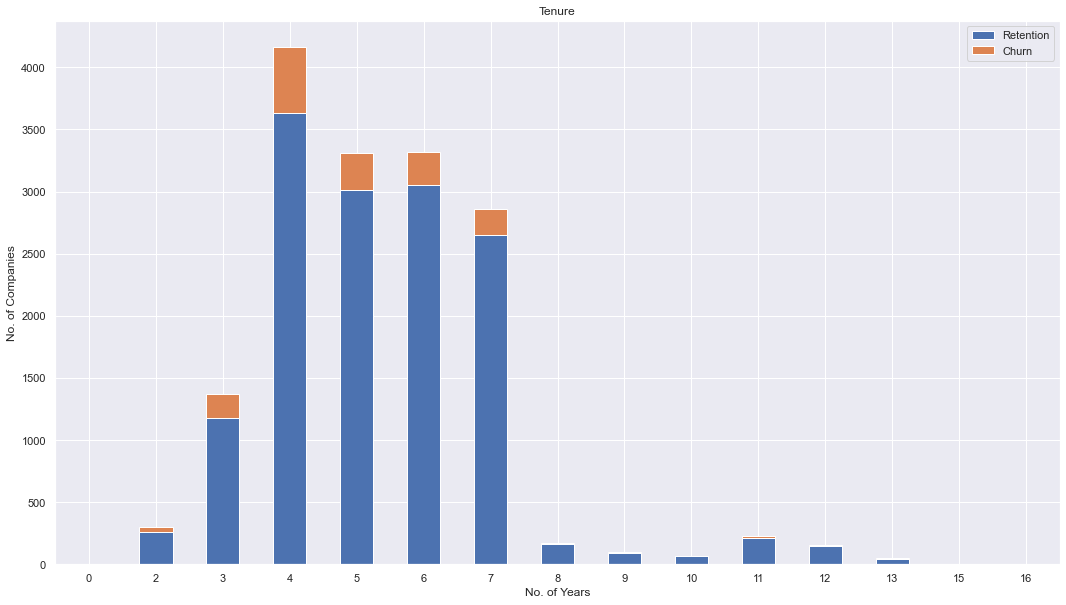

In [16]:
tenure.plot(kind="bar", figsize=(18,10), stacked=True, rot=0, title="Tenure")
# Rename legend
plt.legend(["Retention","Churn"], loc="upper right")
# Labels
plt.ylabel("No. of Companies")
plt.xlabel("No. of Years")
plt.show()

We can clearly that churn is very low for companies which joined recently or that have made the contract a long time ago. With the higher number of churners within the 3-7 years of tenure.

We will also transform the dates provided in such a way that we can make more sense out of those.

months_activ : Number of months active until reference date (Jan 2016)

months_to_end : Number of months of the contract left at reference date (Jan 2016)

months_modif_prod : Number of months since last modification at reference date (Jan 2016)

months_renewal : Number of months since last renewal at reference date (Jan 2016)

To create the month column we will follow a simple process:
1. Subtract the reference date and the column date
2. Convert the timedelta in months
3. Convert to integer (we are not interested in having decimal months)

In [17]:
def convert_months(reference_date, dataframe, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = REFERENCE_DATE - dataframe[column]
    months = (time_delta / np.timedelta64(1,"M")).astype(int)
    return months

In [18]:
# Create reference date as provided on the exercise statement
REFERENCE_DATE = datetime.datetime(2016, 1, 1)

In [19]:
train["months_activ"] = convert_months(REFERENCE_DATE, train, "date_activ")
train["months_to_end"] = -convert_months(REFERENCE_DATE, train, "date_end")
train["months_modif_prod"] = convert_months(REFERENCE_DATE, train, "date_modif_prod")
train["months_renewal"] = convert_months(REFERENCE_DATE, train, "date_renewal")

In [20]:
def plot_churn_by_month(dataframe, column, fontsize_=11):
    """
    Plot churn distribution by monthly variable
    """
    temp = dataframe[[column,"churn","id"]].groupby([column,"churn"])["id"].count().unstack(level=1)
    temp.plot(kind="bar", figsize=(18,10), stacked=True, rot=0, title=column)
    # Rename legend
    plt.legend(["Retention","Churn"], loc="upper right")
    # Labels
    plt.ylabel("No. of Companies")
    plt.xlabel("No. of Months")
    # Set xlabel fontsize
    plt.xticks(fontsize=fontsize_)
    plt.show()

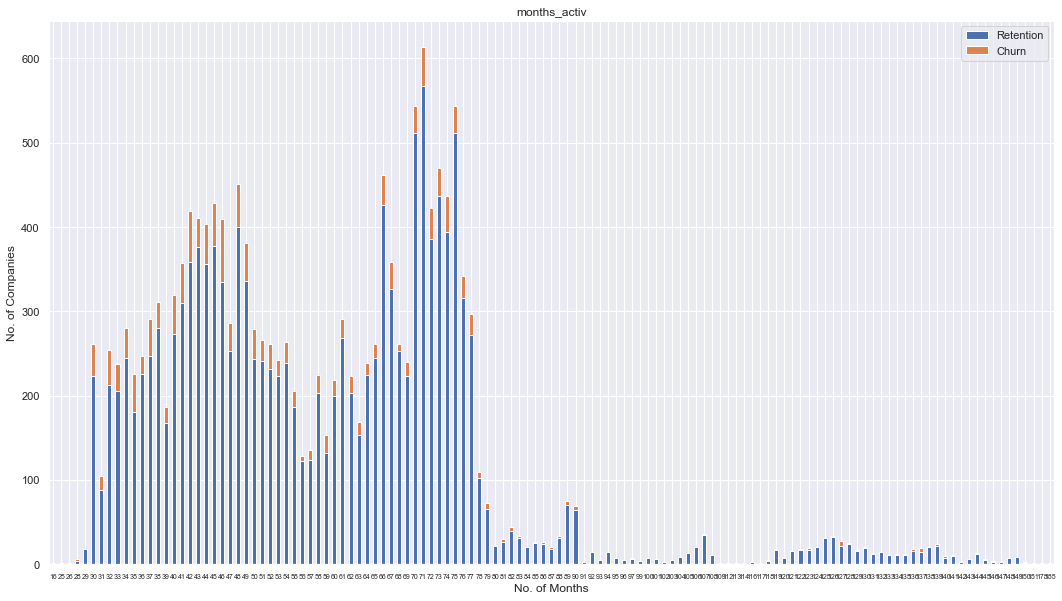

In [21]:
plot_churn_by_month(train, "months_activ", 7)

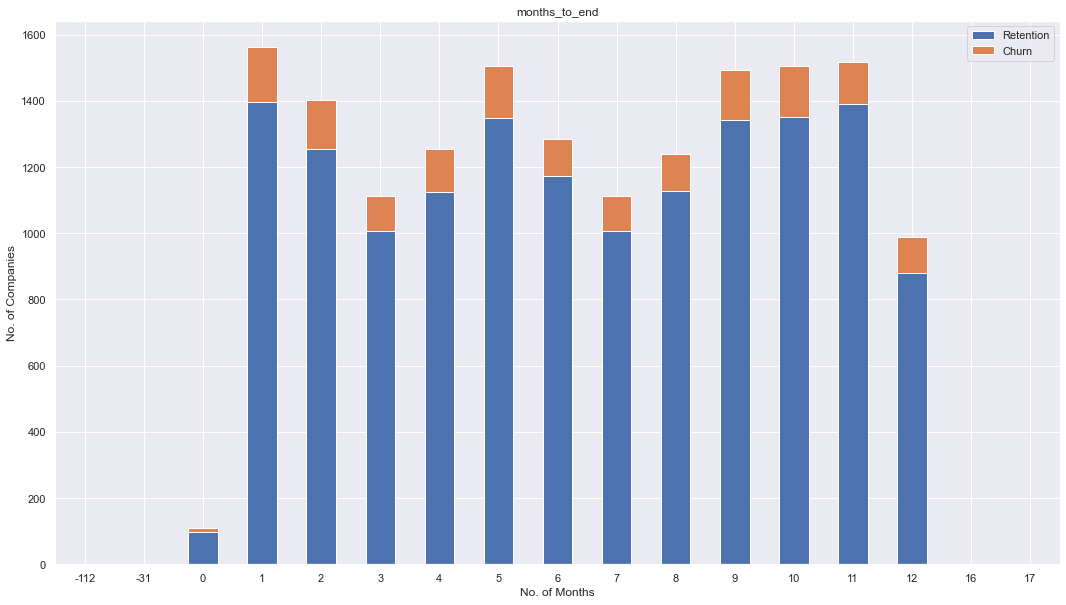

In [22]:
plot_churn_by_month(train, "months_to_end")

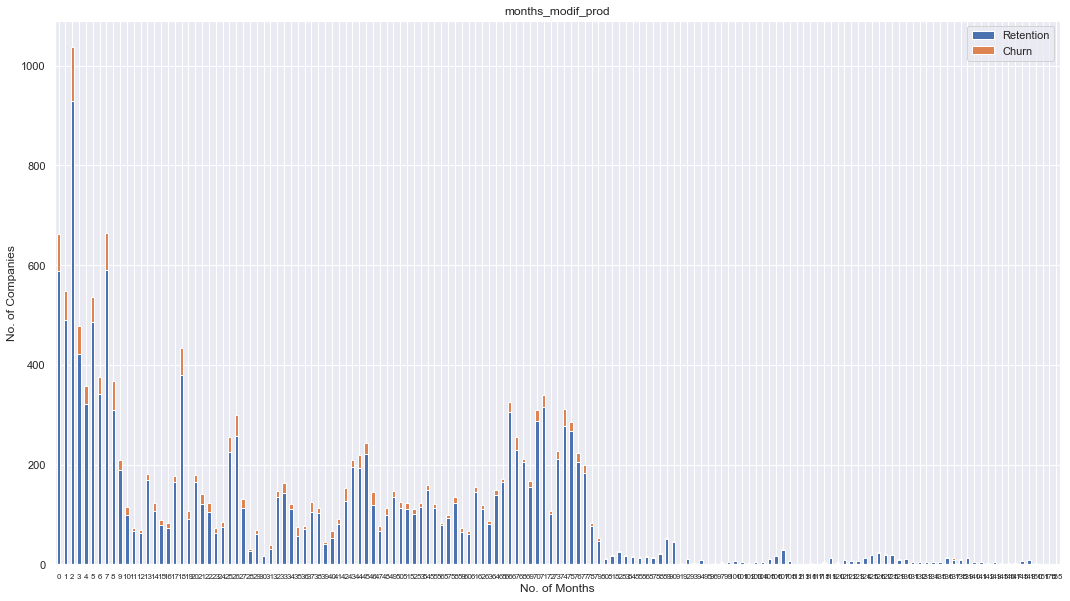

In [23]:
plot_churn_by_month(train, "months_modif_prod", 8)

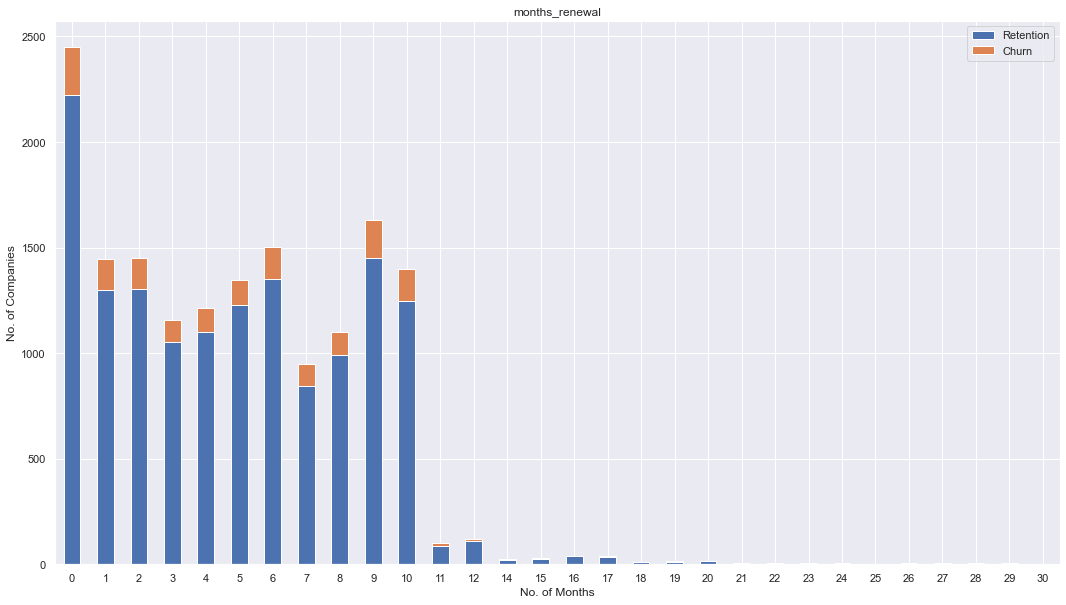

In [24]:
plot_churn_by_month(train, "months_renewal")

In [25]:
# Remove date columns
train.drop(columns=["date_activ","date_end","date_modif_prod","date_renewal"], inplace=True)

### Transforming Boolean Data

For the column has_gas, we will replace t for True or 1 and f for False or 0 . This process is usually referred as One-Hot Encoding.

In [26]:
train["has_gas"] = train["has_gas"].replace(["t","f"], [1,0])

### Categorical Data & Dummy Variables

When training our model we cannot use string data as such, so we will need to encode it into numerical data. The easiest method is mapping each category to an integer ( label encoding ) but this will not work because the model will misunderstand the data to be in some kind of order or hierarchy, 0 < 1 < 2 < 3 ...

For that reason we will use a method with dummy variables or onehot encoder.

#### Categorical Data: channel_sales

What we are doing here relatively simple, we want to convert each category into a new dummy variable which will have 0s and 1s depending whether than entry belongs to that particular category or not.

First of all let's replace the Nan values with a string called null_values_channel.

In [27]:
train["channel_sales"] = train["channel_sales"].fillna("null_values_channel")

Now transform the channel_sales column into categorical data type.

In [28]:
train["channel_sales"] = train["channel_sales"].astype("category")

In [29]:
pd.DataFrame({"Samples in Category": train["channel_sales"].value_counts()})

,Samples in Category
foosdfpfkusacimwkcsosbicdxkicaua,7377
null_values_channel,4218
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


So that means we will create 8 different dummy variables. Each variable will become a different column.

In [30]:
categories_channel = pd.get_dummies(train["channel_sales"], prefix="channel")

In [31]:
# Rename columns for simplicity
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]
categories_channel.head()

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_nul,channel_sdd,channel_usi
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0


We will explain the concept of multicollinearity in the next section. Simply put, multicollinearity is when two or more independent variables in a regression are highly related to one another, such that they do not provide unique or independent information to the regression.

Multicollinearity can affect our models so we will remove one of the columns.

In [32]:
categories_channel.drop(columns=["channel_nul"], inplace=True)

#### Categorical Data: origin_up

First of all let's replace the Nan values with a string called null_values_origin.

In [33]:
train["origin_up"] = train["origin_up"].fillna("null_values_origin")

Now transform the origin_up column into categorical data type.

In [34]:
train["origin_up"] = train["origin_up"].astype("category")

In [35]:
pd.DataFrame({"Samples in Category": train["origin_up"].value_counts()})

,Samples in Category
lxidpiddsbxsbosboudacockeimpuepw,7825
kamkkxfxxuwbdslkwifmmcsiusiuosws,4517
ldkssxwpmemidmecebumciepifcamkci,3664
null_values_origin,87
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


So that means we will create 6 different dummy variables. Each variable will become a different column.

In [36]:
categories_origin = pd.get_dummies(train["origin_up"], prefix="origin")
# Rename columns for simplicity
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]

In [37]:
categories_origin.head(5)

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_nul,origin_usa
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [38]:
categories_origin.drop(columns=["origin_nul"], inplace=True)

### Categorical Data - Feature Engineering

First of all let's replace the Nan values with a string called null_values_activity.

In [39]:
train["activity_new"] = train["activity_new"].fillna("null_values_activity")

In [40]:
categories_activity = pd.DataFrame({"Activity samples": train["activity_new"].value_counts()})
categories_activity

,Activity samples
null_values_activity,9545
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
...,...
falcdfadiaxaafmplkebedawlaifficp,1
cwcwxxdfpcxwfouoaeoofsluifdoxxpe,1
opemwsspmskladcbclpkmilallxmiook,1
xumuokeiidieboawuxkidxufcexecbbl,1


As we can see below there are too many categories with very few number of samples. So we will replace any category with less than 75 samples as null_values_category

In [41]:
# Get the categories with less than 75 samples
to_replace = list(categories_activity[categories_activity["Activity samples"] <= 75].index)
# Replace them with `null_values_categories`
train["activity_new"] = train["activity_new"].replace(to_replace, "null_values_activity")

In [42]:
# Create dummy variables
categories_activity = pd.get_dummies(train["activity_new"], prefix="activity")
# Rename columns for simplicity
categories_activity.columns = [col_name[:12] for col_name in categories_activity.columns]

In [43]:
categories_activity.head()

,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0


In [44]:
categories_activity.drop(columns=["activity_nul"], inplace=True)

#### Merge Dummy Variables to the Main Dataframe

We will merge all the new categories into our main dataframe and remove the old categorical columns.

In [45]:
# Use common index to merge
train = pd.merge(train, categories_channel, left_index=True, right_index=True)
train = pd.merge(train, categories_origin, left_index=True, right_index=True)
train = pd.merge(train, categories_activity, left_index=True, right_index=True)

In [46]:
train.drop(columns=["Unnamed: 0","channel_sales","origin_up","activity_new"], inplace=True)

In [47]:
train.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn', 'tenure',
       'months_activ', 'months_to_end', 'months_modif_prod', 'months_renewal',
       'channel_epu', 'channel_ewp', 'channel_fix', 'channel_foo',
       'channel_lmk', 'channel_sdd', 'channel_usi', 'origin_ewx', 'origin_kam',
       'origin_ldk', 'origin_lxi', 'origin_usa', 'activity_apd',
       'activity_ckf', 'activity_clu', 'activity_cwo', 'activity_fmw',
       'activity_kkk', 'activity_kwu', 'activity_sfi', 'activity_wxe'],
      dtype='object')

### Log Transformation

Remember from the previous exercise that a lot of the variables we are dealing with are highly skewed to the right.

Why is skewness relevant? Skewness is not "bad". Nonetheless, some predective models make fundamental assumptions related to variables being "normally distributed". Hence, the model will perform poorly if the data is highly skewed.

There are several methods in which we can reduce skewness such as square root , cube root , and log. In this case, we will use a log transformation which is usually recommended for right skewed data.

In [48]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,0.184145,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,35.741240,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,0.387615,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,30.609746,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,0.000000,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,0.000000,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,0.000000,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,64.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,1.000000,15042.790000

Particularly relevant to look at the standard deviation std which is very very high for some variables.

Log transformation does not work with negative data, so we will convert the negative values to NaN.

Also we cannot apply a log transformation to 0 valued entries, so we will add a constant 1.

In [49]:
# Remove negative values
train.loc[train.cons_12m < 0, "cons_12m"] = np.nan
train.loc[train.cons_gas_12m < 0, "cons_gas_12m"] = np.nan
train.loc[train.cons_last_month < 0, "cons_last_month"] = np.nan
train.loc[train.forecast_cons_12m < 0, "forecast_cons_12m"] = np.nan
train.loc[train.forecast_cons_year < 0, "forecast_cons_year"] = np.nan
train.loc[train.forecast_meter_rent_12m < 0, "forecast_meter_rent_12m"] = np.nan
train.loc[train.imp_cons < 0, "imp_cons"] = np.nan

In [50]:
# Apply log10 transformation
train["cons_12m"] = np.log10(train["cons_12m"] + 1)
train["cons_gas_12m"] = np.log10(train["cons_gas_12m"] + 1)
train["cons_last_month"] = np.log10(train["cons_last_month"] + 1)
train["forecast_cons_12m"] = np.log10(train["forecast_cons_12m"] + 1)
train["forecast_cons_year"] = np.log10(train["forecast_cons_year"] + 1)
train["forecast_meter_rent_12m"] = np.log10(train["forecast_meter_rent_12m"] + 1)
train["imp_cons"] = np.log10(train["imp_cons"] + 1)

C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

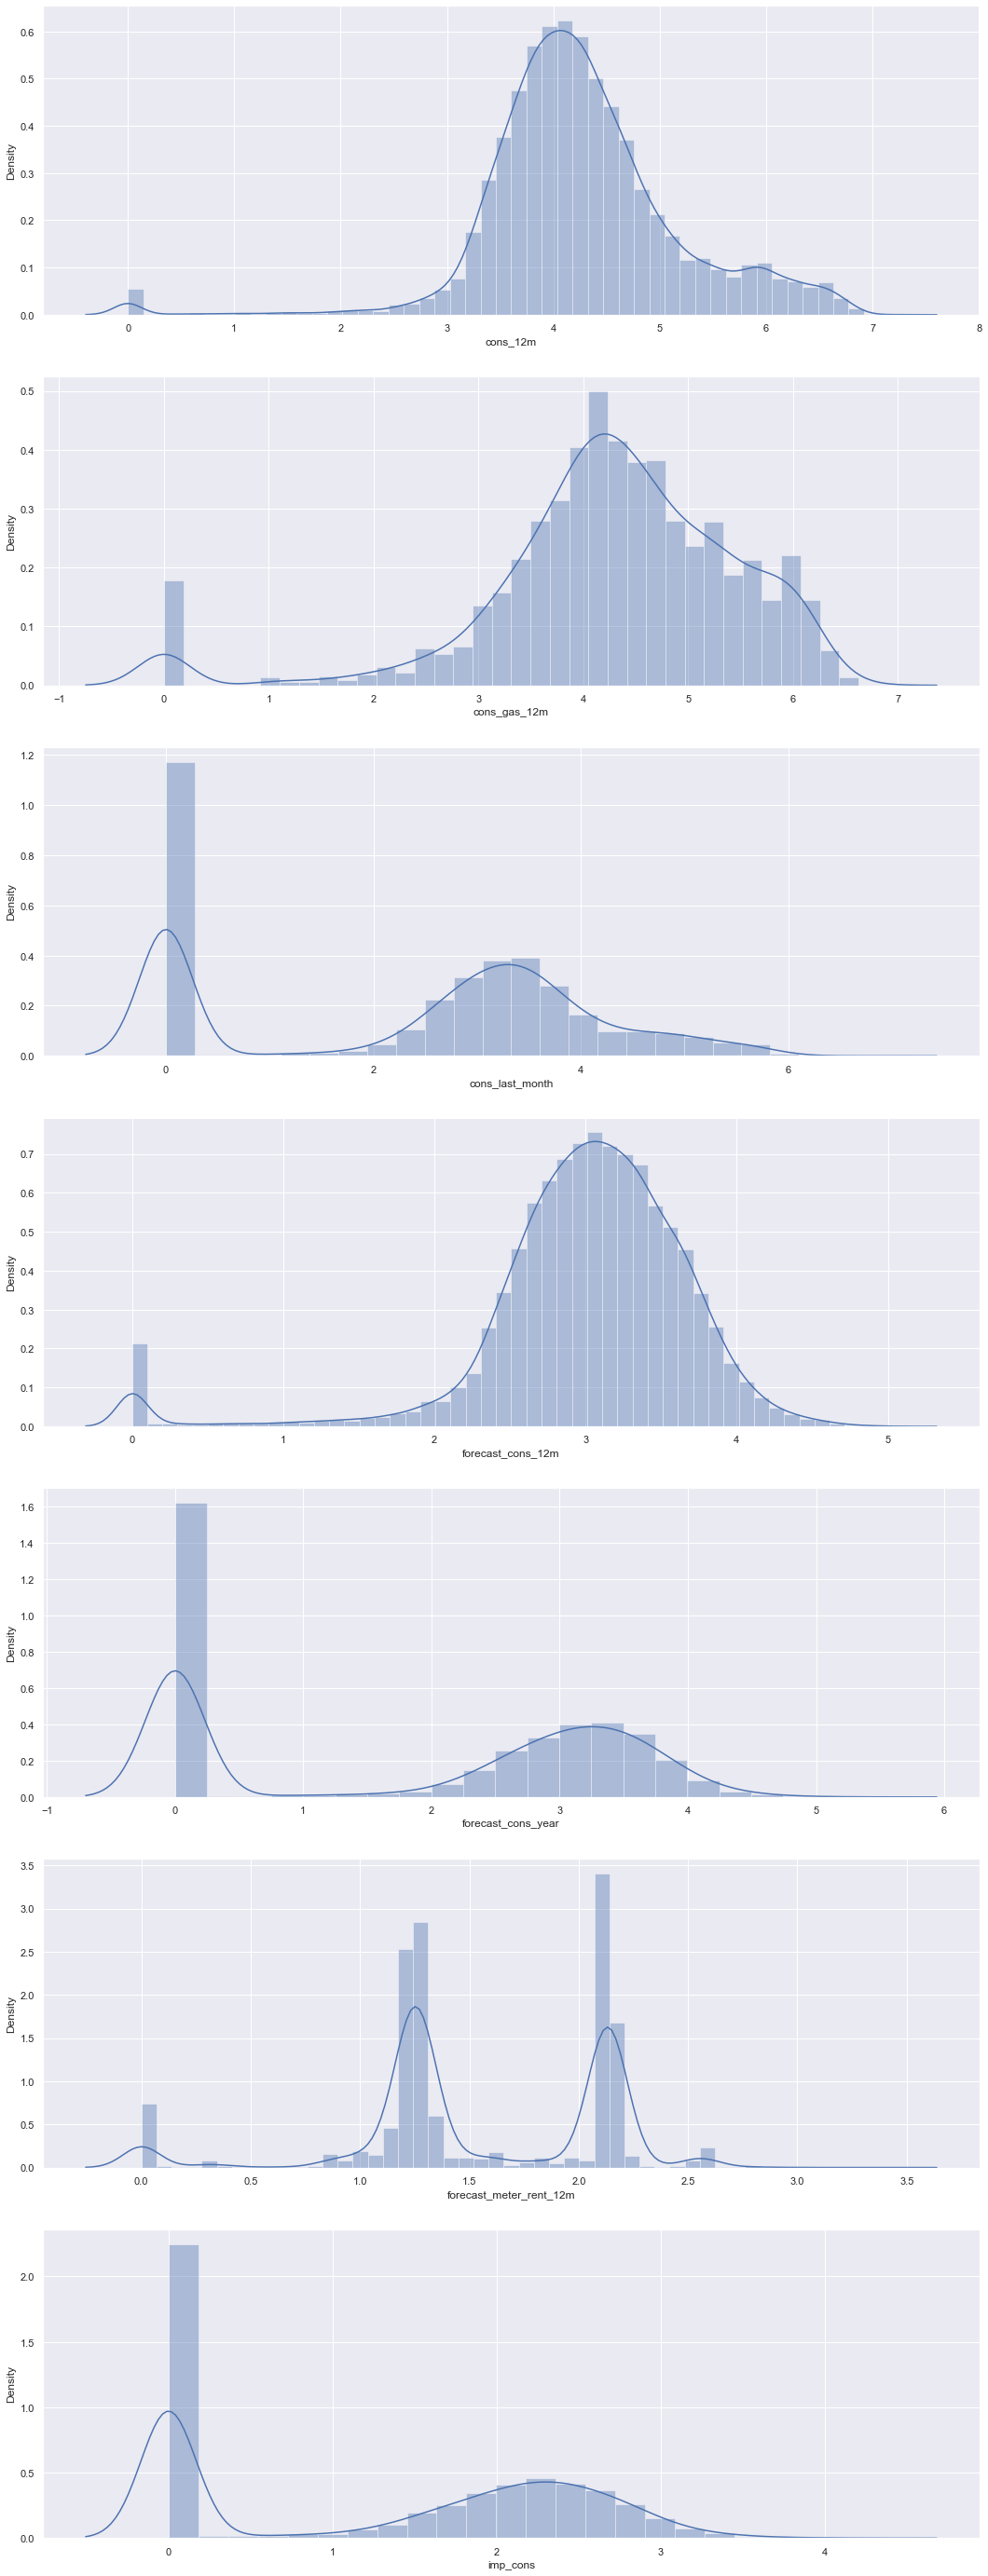

In [51]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot histograms
sns.distplot((train["cons_12m"].dropna()), ax=axs[0])
sns.distplot((train[train["has_gas"] == 1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.distplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.distplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.distplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.distplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Nikhil\Anaconda3\lib\s

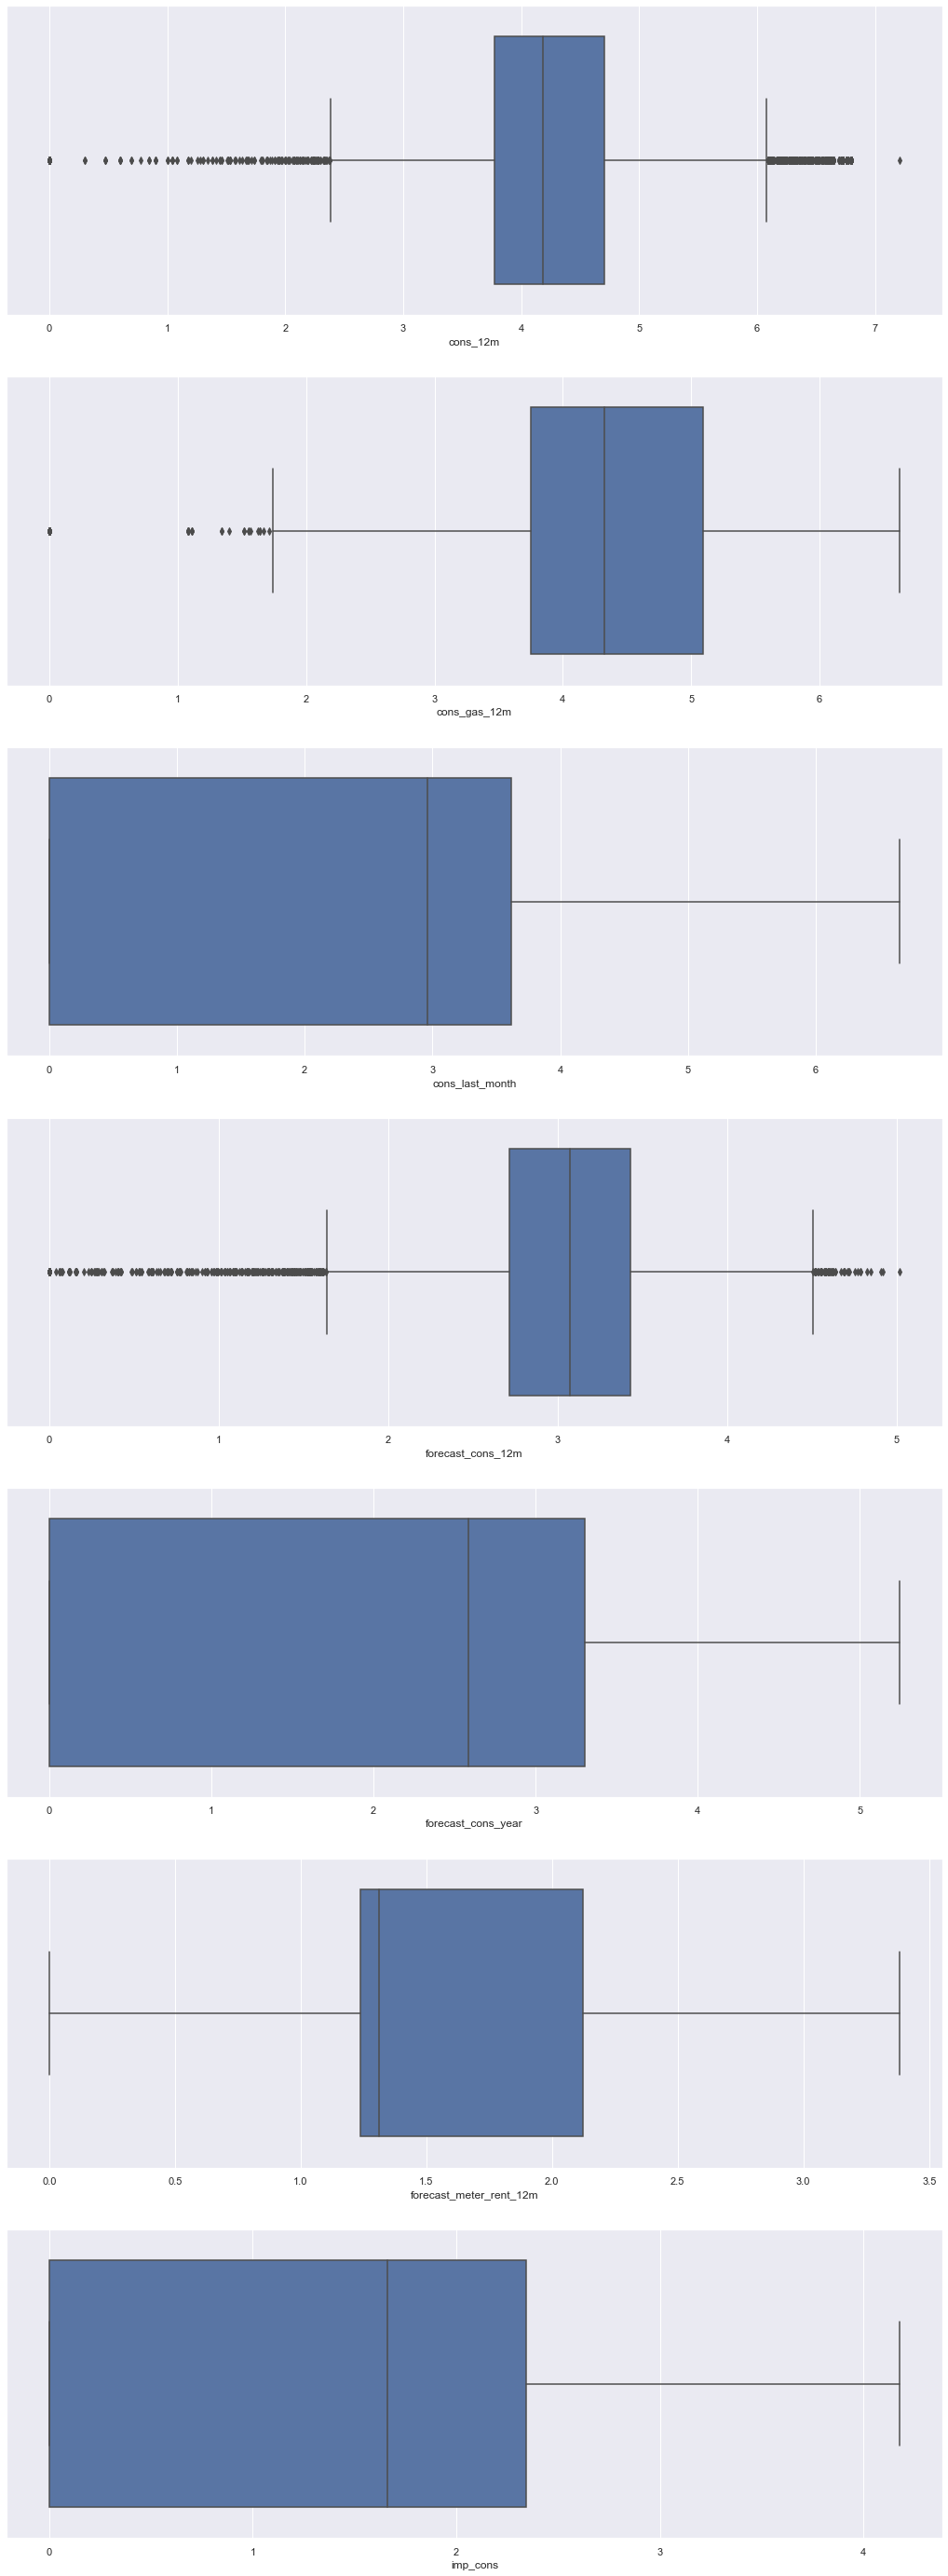

In [52]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"] == 1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [53]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,15970.000000,16092.000000,15970.000000,15970.000000,15970.000000,16096.000000,16069.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496,0.184145,1.305021,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,35.741240,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.160969,0.589394,0.026252,0.048617,5.212252,0.387615,1.165532,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,30.609746,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184,0.000000,0.000000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.086163,44.311378,0.000000,1.662380,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378,0.000000,2.341118,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,64.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710,1.000000,4.177357,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,16.000000,185.000000,17.000000,185.000000,30.000000,1.000000,1.000000,1.000000,1.00

The distributions look much closer to normal distributions now!

Notice how the standard deviation std has changed.

From the boxplots we can still see some values are quite far from the range (outliers). We will deal with them later.

# 2. Highly Correlated Variables

In [54]:
features = features.drop('Unnamed: 0', axis=1)

In [55]:
features.columns

Index(['id', 'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3'],
      dtype='object')

In [56]:
corr_f = features.corr()

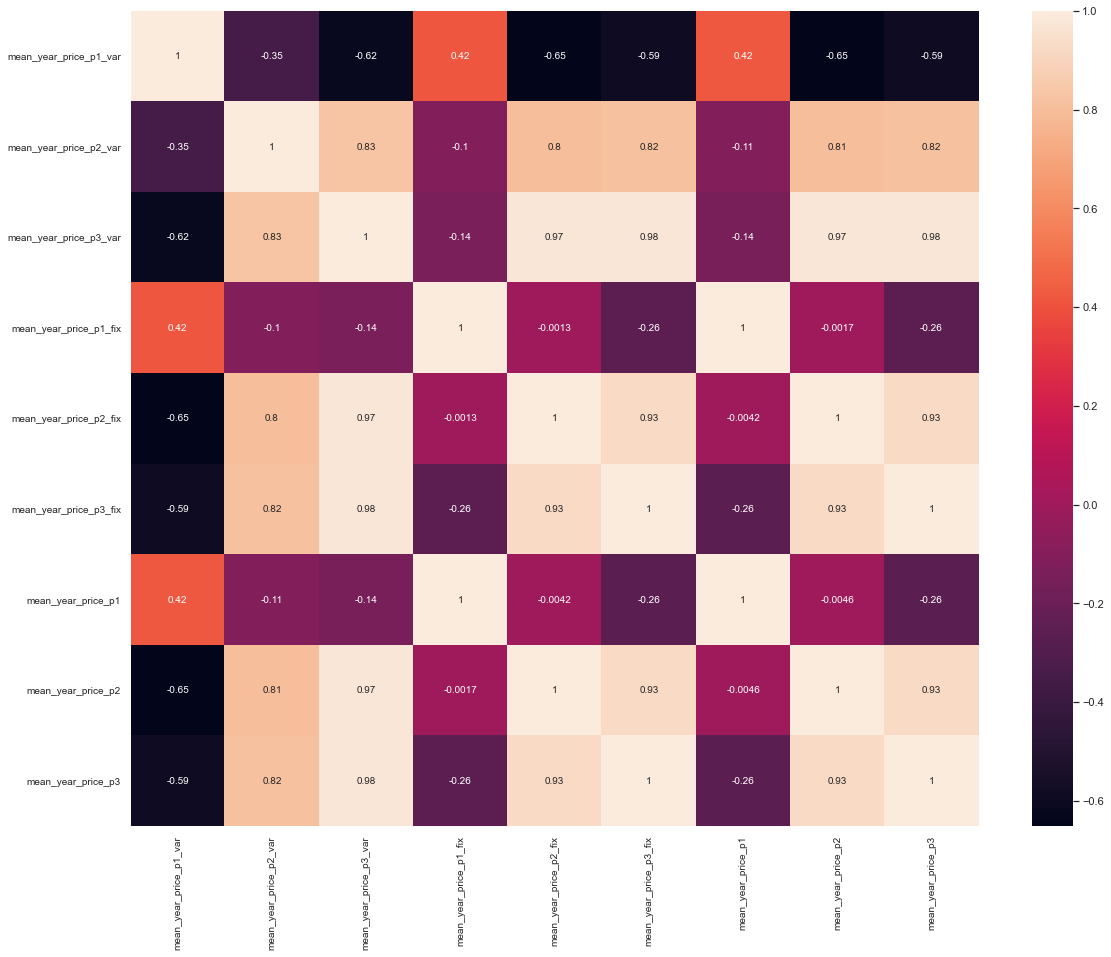

In [58]:
# Plot correlation
plt.figure(figsize=(19,15))
sns.heatmap(corr_f,
            xticklabels=corr_f.columns.values,
            yticklabels=corr_f.columns.values,
            annot=True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

We can remove highly correlated variables.

Multicollinearity happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This can lead to skewed or misleading results. Luckily, decision trees and boosted trees algorithms are immune to multicollinearity by nature. When they decide to split, the tree will choose only one of the perfectly correlated features. However, other algorithms like Logistic Regression or Linear Regression are not immune to that problem and should be fixed before training the model.

In [60]:
corr_t = train.corr()

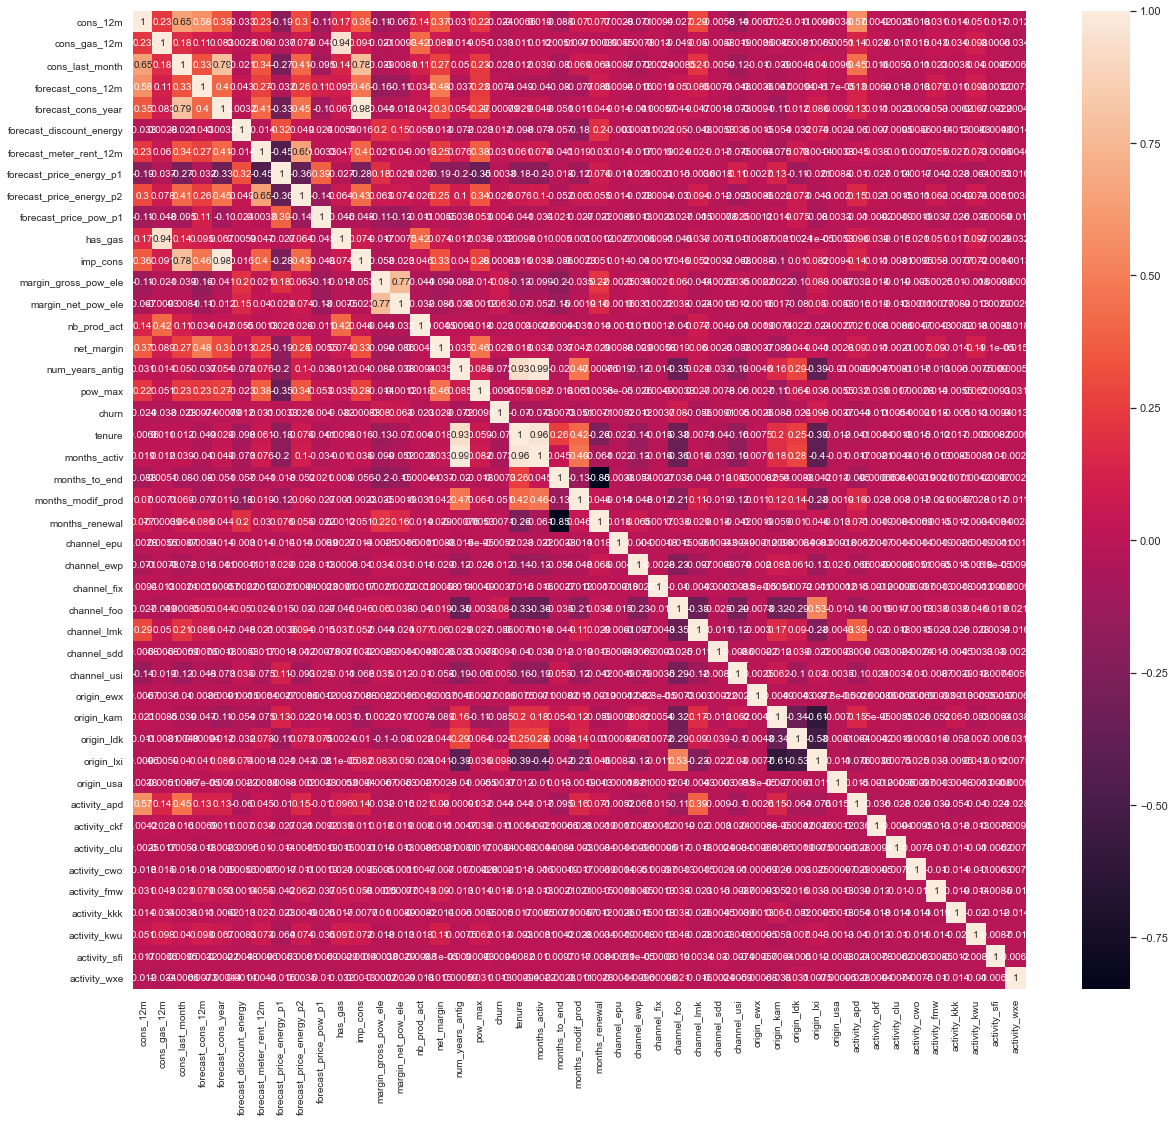

In [61]:
# Plot correlation
plt.figure(figsize=(20,18))
sns.heatmap(corr_t,
            xticklabels=corr_t.columns.values,
            yticklabels=corr_t.columns.values,
            annot=True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

As expected, num_years_antig has a high correlation with months_activ (it provides us the same information).

We can remove variables with very high correlation.

In [62]:
train.drop(columns=["num_years_antig","forecast_cons_year"], inplace=True)

In [63]:
train.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'pow_max', 'churn', 'tenure', 'months_activ',
       'months_to_end', 'months_modif_prod', 'months_renewal', 'channel_epu',
       'channel_ewp', 'channel_fix', 'channel_foo', 'channel_lmk',
       'channel_sdd', 'channel_usi', 'origin_ewx', 'origin_kam', 'origin_ldk',
       'origin_lxi', 'origin_usa', 'activity_apd', 'activity_ckf',
       'activity_clu', 'activity_cwo', 'activity_fmw', 'activity_kkk',
       'activity_kwu', 'activity_sfi', 'activity_wxe'],
      dtype='object')

# 3. Removing Outliers

As we identified during the exploratory phase, the consumption data has several outliers. We are going to remove those outliers.

#### What are the criteria to identify an outlier?

The most common way to identify an outlier are:
1. Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile.
2. Data point that falls outside of 3 standard deviations.

#### What do we do with the outliers?

There are several ways to handle with those outliers such as removing them (this works well for massive datasets) or replacing them with sensible data (works better when the dataset is not that big).

We will replace the outliers with the mean (average of the values excluding outliers).

In [64]:
def replace_outliers_z_score(dataframe, column, Z=3):
    """
    Replace outliers with the mean values using the Z score.
    Nan values are also replaced with the mean values.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column

    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """
    from scipy.stats import zscore

    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])

    # Calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()

    # Replace with mean values
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    no_outliers = dataframe[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z)].shape[0]
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

    # Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")

In [65]:
for c in features.columns:
    if c != "id":
        features = replace_outliers_z_score(features, c)

Replaced: 276  outliers in  mean_year_price_p1_var
Replaced: 0  outliers in  mean_year_price_p2_var
Replaced: 0  outliers in  mean_year_price_p3_var
Replaced: 121  outliers in  mean_year_price_p1_fix
Replaced: 0  outliers in  mean_year_price_p2_fix
Replaced: 0  outliers in  mean_year_price_p3_fix
Replaced: 123  outliers in  mean_year_price_p1
Replaced: 0  outliers in  mean_year_price_p2
Replaced: 0  outliers in  mean_year_price_p3


In [66]:
features.reset_index(drop=True, inplace=True)

As we identified during the exploratory phase, and when carrying out the log transformation, the dataset has several outliers.

In [67]:
def _find_outliers_iqr(dataframe, column):
    """
    Find outliers using the 1.5*IQR rule.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column

    Returns
    -------
    Dict
    With the values of the iqr, lower_bound and upper_bound
    """
    col = sorted(dataframe[column])
    q1, q3 = np.percentile(col, [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    results = {"iqr":iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
    return results


def remove_outliers_iqr(dataframe, column):
    """
    Remove outliers using the 1.5*IQR rule.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column

    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """

    outliers = _find_outliers_iqr(dataframe, column)
    removed = dataframe[(dataframe[column] < outliers["lower_bound"]) |
                        (dataframe[column] > outliers["upper_bound"])].shape
    
    dataframe = dataframe[(dataframe[column] > outliers["lower_bound"]) &
                          (dataframe[column] < outliers["upper_bound"])]
    
    print("Removed:", removed[0], " outliers")
    return dataframe


def remove_outliers_z_score(dataframe, column, Z=3):
    """
    Remove outliers using the Z score. Values with more than 3 are removed.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column

    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """
    from scipy.stats import zscore

    dataframe["zscore"] = zscore(dataframe[column])

    removed = dataframe[(dataframe["zscore"] < -Z) |
                        (dataframe["zscore"] > Z)].shape

    dataframe = dataframe[(dataframe["zscore"] > -Z) &
                          (dataframe["zscore"] < Z)]

    print("Removed:", removed[0], " outliers of ", column)
    return dataframe.drop(columns="zscore")


def replace_outliers_z_score(dataframe, column, Z=3):
    """
    Replace outliers with the mean values using the Z score.
    Nan values are also replaced with the mean values.
    Parameters
    ----------
    dataframe : pandas dataframe
    Contains the data where the outliers are to be found
    column : str
    Usually a string with the name of the column

    Returns
    -------
    Dataframe
    With outliers under the lower and above the upper bound removed
    """
    from scipy.stats import zscore

    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])

    # Calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()

    # Replace with mean values
    no_outliers = dataframe[column].isnull().sum()
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

    # Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")

In [68]:
train = replace_outliers_z_score(train, "cons_12m")
train = replace_outliers_z_score(train, "cons_gas_12m")
train = replace_outliers_z_score(train, "cons_last_month")
train = replace_outliers_z_score(train, "forecast_cons_12m")
#train = replace_outliers_z_score(train, "forecast_cons_year")
train = replace_outliers_z_score(train, "forecast_discount_energy")
train = replace_outliers_z_score(train, "forecast_meter_rent_12m")
train = replace_outliers_z_score(train, "forecast_price_energy_p1")
train = replace_outliers_z_score(train, "forecast_price_energy_p2")
train = replace_outliers_z_score(train, "forecast_price_pow_p1")
train = replace_outliers_z_score(train, "imp_cons")
train = replace_outliers_z_score(train, "margin_gross_pow_ele")
train = replace_outliers_z_score(train, "margin_net_pow_ele")
train = replace_outliers_z_score(train, "net_margin")
train = replace_outliers_z_score(train, "pow_max")
train = replace_outliers_z_score(train, "months_activ")
train = replace_outliers_z_score(train, "months_to_end")
train = replace_outliers_z_score(train, "months_modif_prod")
train = replace_outliers_z_score(train, "months_renewal")

Replaced: 27  outliers in  cons_12m
Replaced: 6  outliers in  cons_gas_12m
Replaced: 46  outliers in  cons_last_month
Replaced: 41  outliers in  forecast_cons_12m
Replaced: 126  outliers in  forecast_discount_energy
Replaced: 4  outliers in  forecast_meter_rent_12m
Replaced: 126  outliers in  forecast_price_energy_p1
Replaced: 126  outliers in  forecast_price_energy_p2
Replaced: 126  outliers in  forecast_price_pow_p1
Replaced: 27  outliers in  imp_cons
Replaced: 13  outliers in  margin_gross_pow_ele
Replaced: 13  outliers in  margin_net_pow_ele
Replaced: 15  outliers in  net_margin
Replaced: 3  outliers in  pow_max
Replaced: 0  outliers in  months_activ
Replaced: 0  outliers in  months_to_end
Replaced: 0  outliers in  months_modif_prod
Replaced: 0  outliers in  months_renewal


In [69]:
train.reset_index(drop=True, inplace=True)

Note: I do like applying a light Z-score of 3, although IQR is usually heavier on the data.

C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Nikhil\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Nikhil\Anaconda3\lib\s

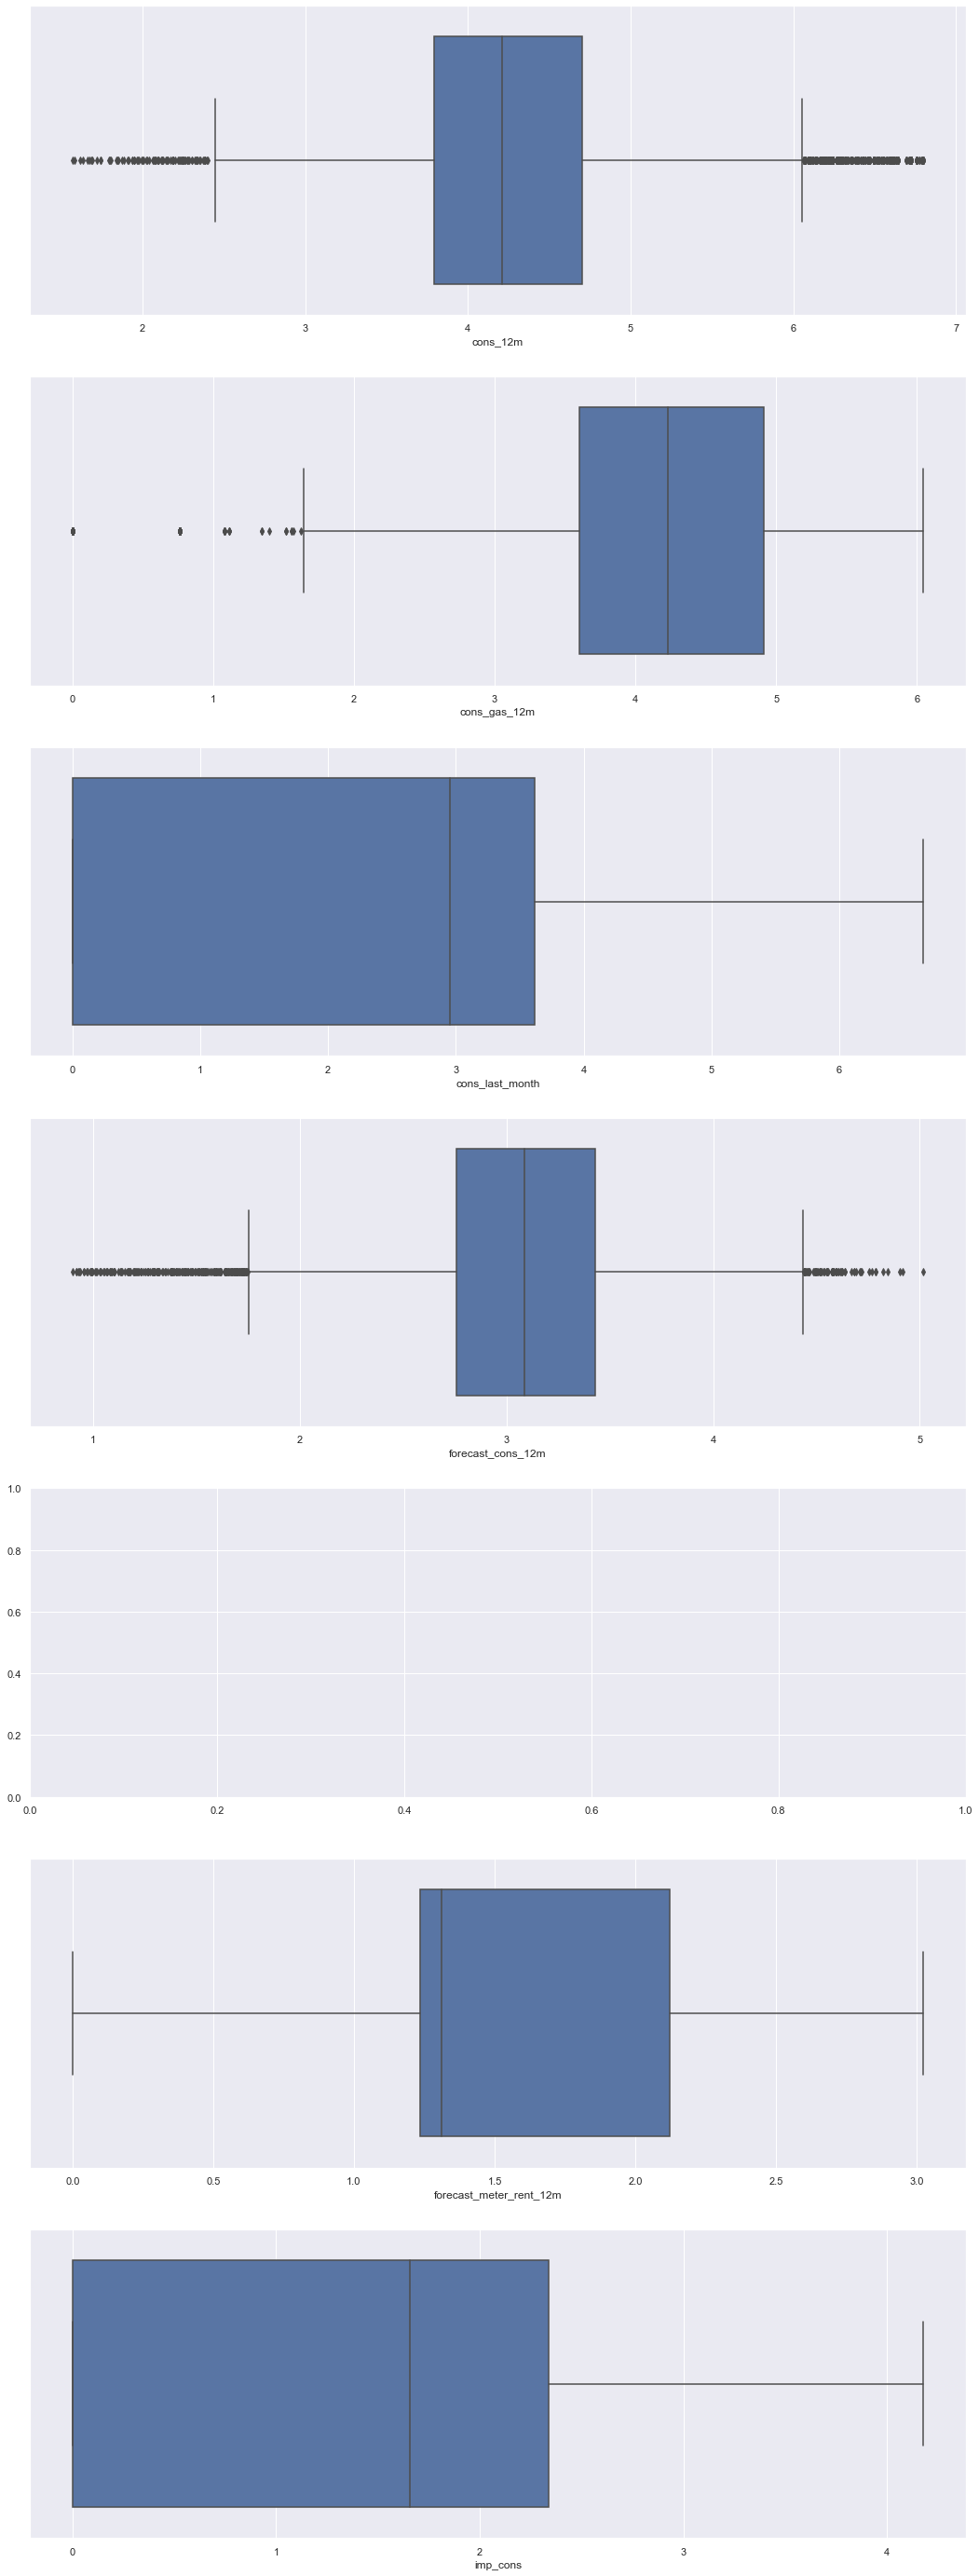

In [70]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"] == 1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
#sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [71]:
print(train.columns)
print(train.shape)
print()
print(features.columns)
print(features.shape)

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'pow_max', 'churn', 'tenure', 'months_activ',
       'months_to_end', 'months_modif_prod', 'months_renewal', 'channel_epu',
       'channel_ewp', 'channel_fix', 'channel_foo', 'channel_lmk',
       'channel_sdd', 'channel_usi', 'origin_ewx', 'origin_kam', 'origin_ldk',
       'origin_lxi', 'origin_usa', 'activity_apd', 'activity_ckf',
       'activity_clu', 'activity_cwo', 'activity_fmw', 'activity_kkk',
       'activity_kwu', 'activity_sfi', 'activity_wxe'],
      dtype='object')
(16096, 44)

Index(['id', 'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_

In [72]:
train.to_csv("train_clean.csv")
features.to_csv("features_clean.csv")